In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize, LinearSegmentedColormap
import matplotlib.colors as mcolors  # Keep this line to avoid redundancy
from sklearn.preprocessing import MinMaxScaler
import decoupler as dc
import PyComplexHeatmap as pch
from PyComplexHeatmap import HeatmapAnnotation, anno_simple, anno_label
from scipy.stats import zscore, ranksums, kruskal, sem, mannwhitneyu
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from adjustText import adjust_text

# Ensure the base matplotlib module is imported
import matplotlib  # Add this line to import the main module

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Specify the path to your Helvetica Neue Regular font file
helvetica_neue_path = "/home/mstier/.local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object using the font path
prop_neue = fm.FontProperties(fname=helvetica_neue_path)

# Get the font name from FontProperties
helvetica_neue_name = prop_neue.get_name()

# Define custom context for font sizes and line thickness using Seaborn
custom_context = {
    'font.size': 7,                    # General font size for the plot
    'axes.labelsize': 7,               # Font size for axis labels
    'axes.titlesize': 7,               # Font size for titles
    'legend.fontsize': 7,              # Font size for legend
    'axes.linewidth': 0.6,             # Line width for axes spines
    'grid.linewidth': 0.6,             # Line width for grid lines
    'lines.linewidth': 0.6,            # Line width for plot lines
    'lines.markersize': 3,             # Size of markers in scatter/line plots
    'patch.linewidth': 0.6,            # Line width for boxplot edges
    'xtick.major.size': 3,             # Length of major ticks on x-axis
    'ytick.major.size': 3,             # Length of major ticks on y-axis
    'xtick.labelsize': 7,              # Font size for x-tick labels
    'ytick.labelsize': 7,              # Font size for y-tick labels
    'legend.title_fontsize': 7,        # Font size for legend title
}

# Define custom style for aesthetic elements like background, grid, and spines using Seaborn
custom_style = {
    'axes.facecolor': 'white',         # Background color of the axes
    'axes.edgecolor': 'black',         # Color of the border around the plot
    'axes.grid': False,                # Disable gridlines
    'grid.color': '#EAEAEA',           # Color of grid lines
    'grid.linestyle': '--',            # Style of the grid lines (dashed)
    'xtick.color': 'black',            # Color of x-axis tick labels
    'ytick.color': 'black',            # Color of y-axis tick labels
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',          # Direction of x-axis ticks
    'ytick.direction': 'out',          # Direction of y-axis ticks
    'axes.spines.left': True,          # Show the left spine (border)
    'axes.spines.bottom': True,        # Show the bottom spine (border)
    'axes.spines.right': False,        # Hide the right spine
    'axes.spines.top': False,          # Hide the top spine
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',                   # Set family to sans-serif
        'font.sans-serif': [helvetica_neue_name],      # Specify Helvetica Neue as the sans-serif font
        'font.size': 7,                                # General font size for the plot
        'axes.labelsize': 7,                           # Font size for axis labels
        'axes.titlesize': 7,                           # Font size for titles
        'legend.fontsize': 7,                          # Font size for legend
        'xtick.labelsize': 7,                          # Font size for x-tick labels
        'ytick.labelsize': 7                           # Font size for y-tick labels
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
# Load AnnData file with labeled cells, noise filtered, and full set of raw counts
adata = sc.read_h5ad('/home/mstier/Downloads/5kHVG-revised-sample-list_128-30-2/10069-MS_raw_label-filtered.h5ad')
adata

In [ ]:
# Generate CPM in the .X attribute
sc.pp.normalize_total(adata, target_sum=1e6)

In [ ]:
# Subset the Anndata object to include the cell type of interest
subset_adata = adata[adata.obs['celltype_fine'] == 'CD4 Treg'].copy()

# Filter out genes with zero counts across all cells
subset_adata = subset_adata[:, subset_adata.X.sum(axis=0) > 0]
subset_adata

In [ ]:
# Create the Compass input tab-delimited text file (tsv)

# Define the groups you want to create Compass input files for
groups = ['NHC']

# Define the output directory
output_directory = '/home/mstier/Downloads/5kHVG-revised-sample-list_128-30-2/Compass/CD4_Treg/'

def create_compass_input(group, subset_adata):
    # Subset the data for the specified group
    group_data = subset_adata[subset_adata.obs['Group'] == group]
    
    # Convert the group data to a CSC matrix
    csc_matrix_result = csc_matrix(group_data.X)
    
    # Create a DataFrame from the CSC matrix
    group_df = pd.DataFrame.sparse.from_spmatrix(csc_matrix_result, columns=group_data.var_names, index=group_data.obs_names).T
    
    # Save the DataFrame as a tab-delimited .tsv file in the specified output directory
    output_file = os.path.join(output_directory, f'{group}_compass_input.tsv')
    group_df.to_csv(output_file, sep='\t')

if __name__ == '__main__':
    # Use multiprocessing to create Compass input files for each group
    with Pool(processes=3) as pool:
        pool.starmap(create_compass_input, [(group, subset_adata) for group in groups])

    # Close the pool of worker processes
    pool.close()

In [ ]:
# Turning on CPLEX [enter in command line in scrnaseq-compass conda environment]
source ~/.bash_profile
echo "export CPLEX_STUDIO_KEY=api_cos_e41e97a4-6ff7-4252-a223-8bcf8de6d6c1" >> .bash_profile
echo "export CPLEX_STUDIO_KEY_SERVER=https://scx-cos.docloud.ibm.com/cos/query/v1/apikeys" >> .bash_profile

In [ ]:
# Run this code in the command line terminal
# Replace directories and input file for each CD4 Treg group

compass --data '/home/mstier/Downloads/5kHVG-revised-sample-list_128-30-2/Compass/CD4_Treg/NHC_compass_input.tsv' --output-dir '/home/mstier/Downloads/5kHVG-revised-sample-list_128-30-2/Compass/CD4_Treg/Output/NHC/' --temp-dir '/home/mstier/Downloads/5kHVG-revised-sample-list_128-30-2/Compass/CD4_Treg/Output/NHC/_tmp' --model RECON2_mat --species homo_sapiens --penalty-diffusion knn --lambda 0 --num-neighbors 30 --microcluster-size 25

In [3]:
# Set the base output directory for all figures
output_dir = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/'

In [ ]:
def import_and_prepare(filepath, cell_type, treatment_group):
    df = pd.read_csv(filepath, sep='\t', index_col=0)
    
    # Convert reaction penalties to consistencies
    df = -np.log(df + 1)

    # Rename columns to include cell type and treatment group at the end
    df.columns = [f"{col}_{treatment_group}_{cell_type}" for col in df.columns]
   
    return df

# Use your defined file_paths_labels with the correct arguments (path, celltype, group)
data_frames = [
    import_and_prepare('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/CD4_T_Naive/Output/NHC/reactions.tsv', 'CD4_T_Naive', 'NHC'),
    import_and_prepare('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/CD4_T_EffEM/Output/NHC/reactions.tsv', 'CD4_T_Eff/EM', 'NHC'),
    import_and_prepare('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/CD4_Treg/Output/NHC/reactions.tsv', 'CD4_Treg', 'NHC'),
    import_and_prepare('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/CD4_T_Naive/Output/CI-Sep/reactions.tsv', 'CD4_T_Naive', 'CI-Sep'),
    import_and_prepare('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/CD4_T_EffEM/Output/CI-Sep/reactions.tsv', 'CD4_T_Eff/EM', 'CI-Sep'),
    import_and_prepare('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/CD4_Treg/Output/CI-Sep/reactions.tsv', 'CD4_Treg', 'CI-Sep')
]

# Concatenate all data frames along columns
merged_df = pd.concat(data_frames, axis=1)
merged_df.reset_index(inplace=True)
merged_df.rename(columns={'index': 'Reaction'}, inplace=True)
merged_df

In [ ]:
# Filter out all reactions in the negative direction
merged_df_filtered = merged_df[~merged_df.iloc[:, 0].str.endswith('_neg')].copy()

# Remove remaining directional specifiers
merged_df_filtered['Reaction'] = merged_df_filtered.iloc[:, 0].str.replace('(_pos)$', '', regex=True)

# Remove reactions with no variability across the dataset
def get_reaction_consistencies(df, min_range=1e-3):
    # Calculate and filter based on variability
    is_variable = (df.max(axis=1, numeric_only=True) - df.min(axis=1, numeric_only=True)) >= min_range
    df_filtered = df.loc[is_variable].copy()
    
    # Normalize numeric columns
    numeric_columns = df_filtered.select_dtypes(include='number').columns
    df_filtered.loc[:, numeric_columns] -= df_filtered[numeric_columns].min().min()
    
    return df_filtered

# Apply the function
merged_df_filtered = get_reaction_consistencies(merged_df_filtered)

# Ensure only numeric columns are considered for the calculations
numeric_columns = merged_df_filtered.select_dtypes(include='number').columns

# Calculate the mean for each reaction (row-wise) using only numeric columns
reaction_means = merged_df_filtered[numeric_columns].mean(axis=1)

# Calculate the standard deviation for each reaction (row-wise) using only numeric columns
reaction_std_devs = merged_df_filtered[numeric_columns].std(axis=1)

# Adding calculated means and standard deviations as new columns
merged_df_filtered['Mean'] = reaction_means
merged_df_filtered['StdDev'] = reaction_std_devs
merged_df_filtered

In [ ]:
# Load and filter RECON2 reaction metadata
def load_and_filter_reaction_metadata(filepath):
    # Load reaction metadata
    reaction_metadata = pd.read_csv(filepath)
    
    # Filter out reactions that don't have an EC number
    reaction_metadata_filtered = reaction_metadata[reaction_metadata['rxn_EC_number'].notna()]
    
    # Further filter by reaction confidence levels (0 and 4)
    reaction_metadata_filtered = reaction_metadata_filtered[reaction_metadata_filtered['rxn_confidence'].isin([0, 4])]
    
    # Adjust subsystem classification for reactions not in the mitochondria (not containing '[m]') and belonging to the Citric acid cycle
    reaction_metadata_filtered.loc[
        (reaction_metadata_filtered['rxn_formula'].str.contains('\[m\]') == False) & 
        (reaction_metadata_filtered['subsystem'] == "Citric acid cycle"), 
        'subsystem'
    ] = 'Other'
    
    return reaction_metadata_filtered

# Load and filter the reaction metadata
reaction_metadata_filtered = load_and_filter_reaction_metadata('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/Compass/rxn_md.csv')

# Display the first few rows to verify
reaction_metadata_filtered

In [ ]:
# Merge reaction consistency data frame with reaction metadata

# If 'Reaction' is the index, reset it to make 'Reaction' a column
if 'Reaction' not in merged_df_filtered.columns:
    merged_df_filtered.reset_index(inplace=True)

# First, ensure that the metadata DataFrame 'rxn_code_nodirection' column is ready for merging
reaction_metadata_filtered = reaction_metadata_filtered.rename(columns={'rxn_code_nodirection': 'Reaction'})

# Perform an inner join to merge and automatically exclude non-matching reactions
combined_df_meta = pd.merge(merged_df_filtered, reaction_metadata_filtered, on='Reaction', how='inner')
combined_df_meta

In [ ]:
# Ensure 'Reaction' is a column. If it's an index, convert it to a column first.
if 'Reaction' not in combined_df_meta.columns:
    combined_df_meta.reset_index(inplace=True)

# Initialize the aggregated DataFrame with 'Reaction' and metadata columns
metadata_columns = ['Reaction', 'rxn_name_long', 'subsystem', 'ind_in_original_recon', 
                    'rxn_EC_number', 'genes_associated_with_rxn', 'rxn_formula', 'rxn_confidence']

aggregated_df = combined_df_meta[metadata_columns].copy()

# Extract common naming pattern from column names for the cluster data
pattern = r"cluster_\d+_(.*)"

# Extract and store the unique patterns for aggregation
unique_patterns = combined_df_meta.columns.str.extract(pattern, expand=False).dropna().unique()

# Aggregate data for each unique pattern
for pattern in unique_patterns:
    # Find columns that end with the current pattern
    matching_columns = combined_df_meta.columns[combined_df_meta.columns.str.contains(f"_{pattern}$")]
    # Aggregate these columns (e.g., mean) and add to 'aggregated_df'
    aggregated_df[pattern] = combined_df_meta[matching_columns].mean(axis=1)

# Carry forward 'Mean' and 'StdDev' from combined_df_meta to aggregated_df
aggregated_df['Mean'] = combined_df_meta['Mean']
aggregated_df['StdDev'] = combined_df_meta['StdDev']

# Verify the structure
aggregated_df

In [ ]:
# Identify numeric data columns for z-score calculation
data_columns = aggregated_df.select_dtypes(include='number').columns.drop(['Mean', 'StdDev'])
# Exclude specific metadata columns by name if they are included in the numeric columns
exclude_columns = ['rxn_name_long', 'subsystem', 'ind_in_original_recon', 
                   'rxn_EC_number', 'genes_associated_with_rxn', 'rxn_formula', 'rxn_confidence']
data_columns = [col for col in data_columns if col not in exclude_columns]

# Ensure 'Mean' and 'StdDev' columns exist and have valid data
if 'Mean' in aggregated_df.columns and 'StdDev' in aggregated_df.columns and not aggregated_df['StdDev'].eq(0).any():
    for col in data_columns:
        # Calculate z-score for each data column
        z_score_column_name = f'z_{col}'
        aggregated_df[z_score_column_name] = (aggregated_df[col] - aggregated_df['Mean']) / aggregated_df['StdDev']
else:
    print("Missing 'Mean'/'StdDev' columns or division by zero detected.")

# Replace infinite z-scores with NaN
aggregated_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Verify structure
aggregated_df

In [ ]:
# Step 1: Exclude specified subsystems directly
aggregated_df_filtered = aggregated_df[
    ~aggregated_df['subsystem'].isin(["Miscellaneous", "Unassigned"])
]

# Step 2: Further exclude subsystems containing "Transport" or "Exchange", or labeled as "Other"
aggregated_df_filtered = aggregated_df_filtered[
    ~aggregated_df_filtered['subsystem'].apply(
        lambda x: "Transport" in x or "Exchange" in x or x == "Other"
    )
]

# Step 3: Calculate counts for remaining subsystems
items, counts = np.unique(aggregated_df_filtered['subsystem'], return_counts=True)
items_with_enough_reactions = [items[i] for i in range(len(items)) if counts[i] > 3]

# Step 4: Keep only subsystems with more than 3 reactions
aggregated_df_filtered = aggregated_df_filtered[
    aggregated_df_filtered['subsystem'].isin(items_with_enough_reactions)
]

aggregated_df_filtered

In [ ]:
# List of subsystems to include
subsystems_to_include = [
    "Alanine and aspartate metabolism", "Arginine and Proline Metabolism",
    "Glycine, serine, alanine and threonine metabolism", "Lysine metabolism",
    "Methionine and cysteine metabolism", "Tryptophan metabolism",
    "Tyrosine metabolism", "Valine, leucine, and isoleucine metabolism",
    "Citric acid cycle", "Oxidative phosphorylation", "Fatty acid oxidation",
    "Fatty acid synthesis", "Glycerophospholipid metabolism", "Sphingolipid metabolism",
    "Glycolysis/gluconeogenesis", "Pyruvate metabolism", "Pentose phosphate pathway",
    "Galactose metabolism", "Inositol phosphate metabolism", "Glutathione metabolism",
    "ROS detoxification", "Urea cycle"
]

# Filter data based on selected subsystems
aggregated_df_filtered = aggregated_df_filtered[aggregated_df_filtered['subsystem'].isin(subsystems_to_include)]

# Sort the DataFrame by subsystem
aggregated_df_filtered = aggregated_df_filtered.sort_values(by='subsystem')

# Reset the index after sorting
aggregated_df_filtered = aggregated_df_filtered.reset_index(drop=True)
aggregated_df_filtered

In [ ]:
# Select columns starting with 'z_' and also include 'subsystem' column
subset_df = aggregated_df_filtered.filter(regex='^z_|subsystem')

# Set 'subsystem' as the index
subset_df.set_index('subsystem', inplace=True)

# Transpose the DataFrame to make reactions the columns
subset_df_transformed = subset_df.T

# Rename rows to remove 'z_' prefix and group cell types
subset_df_transformed = subset_df_transformed.rename(index={
    'z_NHC_CD4_T_Naive': 'CD4 T Naive', 
    'z_NHC_CD4_T_Eff/EM': 'CD4 T Eff/EM',
    'z_NHC_CD4_Treg': 'CD4 Treg',
    'z_CI-Sep_CD4_T_Naive': 'CD4 T Naive', 
    'z_CI-Sep_CD4_T_Eff/EM': 'CD4 T Eff/EM',
    'z_CI-Sep_CD4_Treg': 'CD4 Treg',
})

# Reset the index to bring 'subsystem' back as a column, if needed
subset_df_transformed.reset_index(inplace=True)
subset_df_transformed.rename(columns={'index': 'CellType'}, inplace=True)

# Add a new column 'Group' to differentiate the conditions
subset_df_transformed.insert(0, 'Group', ['NHC', 'NHC', 'NHC', 'CI-Sep', 'CI-Sep', 'CI-Sep'])

In [ ]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(4.5, 1.25))  # Adjust figsize for overall image size

# Define the color stops and their corresponding values
cvals = [-1.0, -0.5, -0.4, -0.33, 0.0, 0.33, 0.4, 0.5, 1.0]
colors = ["#053061", "#b8d8e8", "#dbe9f1", "#ebf1f4", "#FFFFFF", "#f8eee8", "#fbe2d4", "#f9c5ab", "#67001f"]

# Normalize the color values
norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))

# Create the colormap
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", tuples)

# Normalize the color map so that 0 is in the middle
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cax = ax.matshow(subset_df_transformed.iloc[:, 2:], cmap=cmap, norm=norm, aspect='auto')

# Define row labels for the heatmap
row_labels = ['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg', 'CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']

# Remove x-axis tick marks and numbers
ax.set_xticks([])
ax.set_yticks(range(len(row_labels)))
ax.set_yticklabels(row_labels)

for spine in ax.spines.values():
    spine.set_visible(True)  # Make sure the spine is visible
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(0.6)  # Set the width of the spine
    
# Save the heatmap figure
plt.savefig('compass-heatmap.svg', transparent=True)
plt.show()

# Now create the colorbar in a separate figure
fig_cbar, ax_cbar = plt.subplots(figsize=(0.1, 0.6125))
cbar = fig_cbar.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
cbar.set_label('z-score', rotation=90, labelpad=2)

# Save and show the colorbar figure
plt.savefig('compass-heatmap-colorbar.svg', transparent=True)
plt.show()

In [ ]:
# Define the unique subsystem names (assuming these are the column names from the 4th column onwards)
unique_subsystem_names = list(set(subset_df_transformed.columns[2:]))  # Extract unique names
unique_subsystem_names.sort()  # Sort the names to have a consistent order

# Prepare the colors
tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
additional_colors = [(0.97, 0.51, 0.75, 1), (0.6, 0.6, 0.6, 1)]  # Additional colors in RGBA
all_colors = np.vstack((tab20_colors, additional_colors))

# Ensure there are enough colors for all subsystems
assert len(unique_subsystem_names) <= len(all_colors), "Not enough colors for each subsystem."

# Create a dictionary mapping each subsystem to a color
subsystem_to_color = {subsystem: all_colors[i] for i, subsystem in enumerate(unique_subsystem_names)}

# Create figure and axis
fig, ax = plt.subplots(figsize=(4.5, 0.1))  # Match the height of the main heatmap

# Plot each cell with its corresponding color for the first row
for i, subsystem in enumerate(subset_df_transformed.columns[2:]):  # Adjust for correct column indices
    color = subsystem_to_color[subsystem]
    ax.add_patch(patches.Rectangle((i, 0), 1, 1, color=color))

# Set axis limits and adjust labels
ax.set_xlim(0, len(subset_df_transformed.columns[2:]))
ax.set_ylim(0, 1)
ax.axis('off')  # Hide the axis for a cleaner look

# Create a custom legend
legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=subsystem_to_color[subsystem], markersize=10, label=subsystem) for subsystem in unique_subsystem_names]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')


# Save the figure
plt.savefig('heatmap-label.svg', transparent=True)
plt.show()

In [ ]:
combined_df_meta.iloc[0:5]

In [ ]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Filter combined_df_meta for Tryptophan metabolism
tryptophan_df = combined_df_meta[combined_df_meta['subsystem'] == "Tryptophan metabolism"]

# Define columns for each group
group_1_columns = tryptophan_df.filter(regex='^cluster_\d+_NHC_CD4_Treg').columns
group_2_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_Treg').columns

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Reaction', 'Statistic', 'P_Value', 'Cohens_d'])

# Perform analysis for each reaction within Tryptophan metabolism
for reaction in tryptophan_df['Reaction'].unique():
    group1 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_1_columns].values.flatten()
    group2 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_2_columns].values.flatten()
    
    # Perform Wilcoxon rank-sum test and calculate Cohen's d
    stat, p_value = ranksums(group2, group1)
    d = cohens_d(group2, group1)
    
    # Append results
    results_df = results_df.append({'Reaction': reaction, 'Statistic': stat, 'P_Value': p_value, 'Cohens_d': d}, ignore_index=True)

# Apply Benjamini-Hochberg correction to p-values
p_vals = results_df['P_Value'].values
_, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
results_df['p_value_adj'] = pvals_corrected

# Plot Cohen's d vs. adjusted p-value
plt.figure(figsize=(2.25, 1.5))
plt.scatter(results_df['Cohens_d'], -np.log10(results_df['p_value_adj']), color='#2DABB9', alpha=1)

# Add vertical and horizontal dashed lines
plt.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=0.7)

# Prepare labels for significant points
texts = []
for i, row in results_df.iterrows():
    if row['p_value_adj'] < 0.05 and (row['Cohens_d'] > 0.2 or row['Cohens_d'] < -0.2):
        texts.append(plt.text(row['Cohens_d'], -np.log10(row['p_value_adj']), row['Reaction'], ha='left'))

# Set axis labels, title, and ticks
plt.xlabel("Cohen's d")
plt.ylabel(r"$-\log_{10}(\mathrm{BH-adjusted\ p})$")
plt.title("Treg: CI-Sep vs. NHC")
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.xlim(-1, 1.0)
plt.ylim(-0.5, 10.5)

# Use adjustText to repel labels and add connecting lines
adjust_text(
    texts,
    force_text=(0.1, 0.1),
    force_static=(0.3, 0.4),
    force_explode=(0.3, 0.5),
    expand=(1.5, 1.5),
    ensure_inside_axes=False,
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

# Show the plot
plt.savefig('compass_treg_cisep-vs-nhc.svg', transparent=True)
plt.show()

In [ ]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Filter combined_df_meta for Tryptophan metabolism
tryptophan_df = combined_df_meta[combined_df_meta['subsystem'] == "Tryptophan metabolism"]

# Define columns for each group, making CI-Sep_CD4_T_Naive group 1 and CI-Sep_CD4_Treg group 2
group_1_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_T_Naive').columns
group_2_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_Treg').columns

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Reaction', 'Statistic', 'P_Value', 'Cohens_d'])

# Perform analysis for each reaction within Tryptophan metabolism
for reaction in tryptophan_df['Reaction'].unique():
    group1 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_1_columns].values.flatten()
    group2 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_2_columns].values.flatten()
    
    # Perform Wilcoxon rank-sum test and calculate Cohen's d
    stat, p_value = ranksums(group2, group1)
    d = cohens_d(group2, group1)
    
    # Append results
    results_df = results_df.append({'Reaction': reaction, 'Statistic': stat, 'P_Value': p_value, 'Cohens_d': d}, ignore_index=True)

# Apply Benjamini-Hochberg correction to p-values
p_vals = results_df['P_Value'].values
_, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
results_df['p_value_adj'] = pvals_corrected

# Plot Cohen's d vs. adjusted p-value
plt.figure(figsize=(2.25, 1.5))
plt.scatter(results_df['Cohens_d'], -np.log10(results_df['p_value_adj']), color='#2DABB9', alpha=1)

# Add vertical and horizontal dashed lines
plt.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=0.7)

# Prepare labels for significant points
texts = []
for i, row in results_df.iterrows():
    if row['p_value_adj'] < 0.05 and (row['Cohens_d'] > 0.2 or row['Cohens_d'] < -0.2):
        texts.append(plt.text(row['Cohens_d'], -np.log10(row['p_value_adj']), row['Reaction'], ha='left'))

# Set axis labels, title, and ticks
plt.xlabel("Cohen's d")
plt.ylabel(r"$-\log_{10}(\mathrm{BH-adjusted\ p})$")
plt.title("CI-Sep: Treg vs. Naive")
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.xlim(-1, 1)
plt.ylim(-0.5, 10.5)

# Use adjustText to repel labels and add connecting lines
adjust_text(
    texts,
    force_text=(0.5, 0.5),
    force_static=(0.5, 0.5),
    force_explode=(0.5, 0.1),
    expand=(1.2, 1.2),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

# Save and show the plot
plt.savefig('compass_cisep_treg-vs-naive.svg', transparent=True)
plt.show()

In [ ]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Filter combined_df_meta for Tryptophan metabolism
tryptophan_df = combined_df_meta[combined_df_meta['subsystem'] == "Tryptophan metabolism"]

# Define columns for each group, making CI-Sep_CD4_T_EffEM group 1 and CI-Sep_CD4_Treg group 2
group_1_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_T_Eff/EM').columns
group_2_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_Treg').columns

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Reaction', 'Statistic', 'P_Value', 'Cohens_d'])

# Perform analysis for each reaction within Tryptophan metabolism
for reaction in tryptophan_df['Reaction'].unique():
    group1 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_1_columns].values.flatten()
    group2 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_2_columns].values.flatten()
    
    # Perform Wilcoxon rank-sum test and calculate Cohen's d
    stat, p_value = ranksums(group2, group1)
    d = cohens_d(group2, group1)
    
    # Append results
    results_df = results_df.append({'Reaction': reaction, 'Statistic': stat, 'P_Value': p_value, 'Cohens_d': d}, ignore_index=True)

# Apply Benjamini-Hochberg correction to p-values
p_vals = results_df['P_Value'].values
_, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
results_df['p_value_adj'] = pvals_corrected

# Plot Cohen's d vs. adjusted p-value
plt.figure(figsize=(2.25, 1.5))
plt.scatter(results_df['Cohens_d'], -np.log10(results_df['p_value_adj']), color='#2DABB9', alpha=1)

# Add vertical and horizontal dashed lines
plt.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=0.7)

# Prepare labels for significant points
texts = []
for i, row in results_df.iterrows():
    if row['p_value_adj'] < 0.05 and (row['Cohens_d'] > 0.2 or row['Cohens_d'] < -0.2):
        texts.append(plt.text(row['Cohens_d'], -np.log10(row['p_value_adj']), row['Reaction'], ha='left'))

# Set axis labels, title, and ticks
plt.xlabel("Cohen's d")
plt.ylabel(r"$-\log_{10}(\mathrm{BH-adjusted\ p})$")
plt.title("CI-Sep: Treg vs. Eff/EM")
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.xlim(-1, 1)
plt.ylim(-0.5, 10.5)

# Use adjustText to repel labels and add connecting lines
adjust_text(
    texts,
    force_text=(0.5, 0.5),
    force_static=(0.5, 0.4),
    force_explode=(0.7, 0.1),
    expand=(1.2, 1.2),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

# Save and show the plot
plt.savefig('compass_cisep_treg-vs-effem.svg', transparent=True)
plt.show()

In [ ]:
adata = sc.read_h5ad('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/10069-MS_5kHVG-revised_UMAP-label-filtered.h5ad')
adata

In [ ]:
# Ensure the gene of interest is in the dataset
gene = 'SLC7A5'
if gene not in adata.var_names:
    raise ValueError(f"Gene {gene} not found in adata.")

# Create the UMAP plot
sc.pl.umap(
    adata,
    color=gene,
    layer='scVI_normalized',
    cmap='inferno_r',
    size=1,
    vmin=1,
    title=f"{gene}",
    frameon=True,
    show=False
)

# Adjust plot size and customize axes
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(1.625, 1.625)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Ensure a border around all four edges
for spine in ax.spines.values():
    spine.set_visible(True)

# Show the plot
plt.savefig('umap_slc7a5.png', dpi=600)
plt.show()

In [ ]:
# Ensure the gene of interest is in the dataset
gene = 'FOXP3'
if gene not in adata.var_names:
    raise ValueError(f"Gene {gene} not found in adata.")

# Create the UMAP plot without showing it yet
sc.pl.umap(
    adata,
    color=gene,
    layer='scVI_normalized',
    cmap='inferno_r',
    size=1,
    vmin=1,
    title=f"{gene}",
    frameon=True,
    show=False
)

# Adjust plot size and customize axes
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(1.25, 1.25)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Ensure a border around all four edges
for spine in ax.spines.values():
    spine.set_visible(True)

# Show the plot
plt.savefig('umap_foxp3.png', dpi=600)
plt.show()

In [ ]:
# Ensure the gene of interest is in the dataset
gene = 'KMO'

# Create the UMAP plot without showing it yet
sc.pl.umap(
    adata,
    color=gene,
    use_raw=True,
    cmap='inferno_r',
    size=1,
    title=f"{gene}",
    frameon=True,
    show=False
)

# Adjust plot size and customize axes
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(1.25, 1.25)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Ensure a border around all four edges
for spine in ax.spines.values():
    spine.set_visible(True)

# Show the plot
# plt.savefig('umap_ahr.png', dpi=600)
plt.show()

In [ ]:
# Load the data and name the first column as 'gene'
file_path = "/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4Treg_CI-Sep-vs-NHC.csv"
data = pd.read_csv(file_path, index_col=0)
data.reset_index(inplace=True)
data.rename(columns={'index': 'gene'}, inplace=True)

# Set thresholds for significance
log2fc_threshold = 0.58
padj_threshold = 0.05

# Create the plot with specified dimensions
plt.figure(figsize=(1.25, 1.25))

# Plot non-significant genes in grey
non_significant = data[(data['padj'] >= padj_threshold) | ((data['log2FoldChange'] <= log2fc_threshold) & (data['log2FoldChange'] >= -log2fc_threshold))]
plt.scatter(non_significant['log2FoldChange'], -np.log10(non_significant['padj']),
            c='#BBBBBB', s=5)

# Plot upregulated significant genes in red
upregulated = data[(data['log2FoldChange'] > log2fc_threshold) & (data['padj'] < padj_threshold)]
plt.scatter(upregulated['log2FoldChange'], -np.log10(upregulated['padj']),
            c='#ff6666', s=5)

# Plot downregulated significant genes in blue
downregulated = data[(data['log2FoldChange'] < -log2fc_threshold) & (data['padj'] < padj_threshold)]
plt.scatter(downregulated['log2FoldChange'], -np.log10(downregulated['padj']),
            c='#2b76f0', s=5)

# Highlight and label SLC7A5
texts = []
slc7a5 = data[data['gene'] == 'SLC7A5']
if not slc7a5.empty:
    plt.scatter(slc7a5['log2FoldChange'], -np.log10(slc7a5['padj']),
                c='#ff6666', s=5, edgecolor='k', alpha=1, zorder=3)  # Ensure SLC7A5 is plotted on top
    for _, row in slc7a5.iterrows():
        # Create the text label and add it to the list for adjust_text
        texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), 'SLC7A5', ha='left'))

# Adjust the text labels to avoid overlap, with lines connecting to points
adjust_text(
    texts,
    expand=(4, 4),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

# Add horizontal and vertical threshold lines
plt.axvline(x=log2fc_threshold, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=-log2fc_threshold, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=-np.log10(padj_threshold), color='grey', linestyle='--', linewidth=0.5)

# Label the axes with specified ticks and limits
plt.xlabel(r'Fold Change (log$_2$)')
plt.ylabel(r'$-\log_{10}(\mathrm{adjusted\ p})$')
plt.ylim(0, 20)
plt.yticks(np.arange(0, 21, 5))
plt.xlim(-3, 3)
plt.xticks(np.arange(-3, 4, 1))

# Set title and adjust layout for publication
plt.title('CI-Sep Treg vs. NHC Treg')

# Show the plot
plt.savefig('dge_volcano_treg_slc7a5.svg', transparent=True)
plt.show()

In [ ]:
# Load the raw label-filtered AnnData object
adata_raw = sc.read_h5ad('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/10069-MS_raw_label-filtered.h5ad')

# Filter for only NHC and CI-Sep groups and specific cell types
adata_raw_filtered = adata_raw[adata_raw.obs['Group'].isin(['NHC', 'CI-Sep']) & 
                               adata_raw.obs['celltype_fine'].isin(['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg'])].copy()

In [ ]:
# Step 1: Generate pseudobulks by sample and cell type within each group
pdata = dc.get_pseudobulk(
    adata=adata_raw_filtered,
    sample_col='orig.ident',       # Pseudobulk by each sample
    groups_col='celltype_fine',    # Further split by cell type within each sample
    mode='sum',                    # Sum counts for pseudobulking
    min_cells=20,                  # Minimum cells required per pseudobulk sample
    min_counts=1000                # Minimum counts required per pseudobulk sample
)

# Step 2: Normalize pseudobulked counts to CPM
sc.pp.normalize_total(pdata, target_sum=1e6)

# Create a unique mapping of orig.ident to Group using a dictionary
group_mapping = adata_raw.obs[['orig.ident', 'Group']].drop_duplicates().set_index('orig.ident')['Group'].to_dict()

# Map Group information back to pdata
pdata.obs['Group'] = pdata.obs['orig.ident'].map(group_mapping)
pdata.obs['Group_CellType'] = pdata.obs['Group'] + " - " + pdata.obs['celltype_fine']

In [ ]:
# Extract normalized SLC7A5 expression values for each sample-cell type combination
slc7a5_expression = pdata[:, 'SLC7A5'].X.toarray().flatten()

# Create DataFrame for plotting
df = pd.DataFrame({
    'Sample': pdata.obs['orig.ident'],
    'Group_CellType': pdata.obs['Group_CellType'],
    'Normalized_SLC7A5': slc7a5_expression
})

# Define the simplified x-axis labels and corresponding colors
group_order = [
    'NHC - CD4 T Naive', 'NHC - CD4 T Eff/EM', 'NHC - CD4 Treg',
    'CI-Sep - CD4 T Naive', 'CI-Sep - CD4 T Eff/EM', 'CI-Sep - CD4 Treg'
]
simple_labels = ['Naive', 'Eff/EM', 'Treg', 'Naive', 'Eff/EM', 'Treg']
group_palette = {
    'NHC - CD4 T Naive': '#BBBBBB', 'NHC - CD4 T Eff/EM': '#BBBBBB', 'NHC - CD4 Treg': '#BBBBBB',
    'CI-Sep - CD4 T Naive': '#9F4A96', 'CI-Sep - CD4 T Eff/EM': '#9F4A96', 'CI-Sep - CD4 Treg': '#9F4A96'
}

# Set up plot dimensions
fig, ax = plt.subplots(figsize=(1, 1.25))

# Create boxplot with defined style
sns.boxplot(
    data=df, x='Group_CellType', y='Normalized_SLC7A5', order=group_order, palette=group_palette,
    showfliers=False, boxprops={'edgecolor': 'black', 'linewidth': 0.6},
    whiskerprops={'color': 'black', 'linewidth': 0.6}, capprops={'color': 'black', 'linewidth': 0.6},
    medianprops={'color': 'black', 'linewidth': 0.6}, width=0.75, ax=ax
)

# Overlay individual data points using a strip plot
sns.stripplot(
    data=df, x='Group_CellType', y='Normalized_SLC7A5', order=group_order,
    jitter=True, marker='o', size=2, color='white', edgecolor='black', linewidth=0.6, zorder=3, ax=ax
)

# Set custom x-ticks and labels
ax.set_xticks(np.arange(len(group_order)))
ax.set_xticklabels(simple_labels, rotation=45, ha='center')

# Adjust y-axis and add label
ax.set_ylabel('Norm Exp')
ax.tick_params(axis='y', direction='out', length=3, width=0.6, pad=1)
ax.tick_params(axis='x', direction='out', length=3, width=0.6, pad=1)

# Set y-axis limits and ticks
ax.set_ylim(0, None)
ax.set_yticks(np.arange(0, ax.get_ylim()[1], 10))

# Set title
ax.set_title('SLC7A5')

# Display the plot
plt.savefig('slc7a5_allcd4.svg')
plt.show()

In [ ]:
# Load the dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure6/2024-05-02_flow_KYN-uptake_MFI_python-input.csv'
df = pd.read_csv(file_path)

# Filter data for relevant groups and melt for easy plotting
df_filtered = df[df['Group'].isin(['NHC', 'CI-Sep'])].melt(
    id_vars=['SampleID', 'Group'],
    value_vars=['CD4 T Naive', 'CD4 T EM', 'Treg'],
    var_name='CellType', value_name='MFI'
)

# Define order and color palette for the separate bars
group_order = [
    'NHC - CD4 T Naive', 'NHC - CD4 T EM', 'NHC - Treg',
    'CI-Sep - CD4 T Naive', 'CI-Sep - CD4 T EM', 'CI-Sep - Treg'
]
group_palette = {
    'NHC - CD4 T Naive': '#BBBBBB', 'NHC - CD4 T EM': '#BBBBBB', 'NHC - Treg': '#BBBBBB',
    'CI-Sep - CD4 T Naive': '#9F4A96', 'CI-Sep - CD4 T EM': '#9F4A96', 'CI-Sep - Treg': '#9F4A96'
}
simple_labels = ['Naive', 'Eff/EM', 'Treg', 'Naive', 'Eff/EM', 'Treg']

# Add a column for combined group-celltype labels
df_filtered['Group_CellType'] = df_filtered['Group'] + ' - ' + df_filtered['CellType']

# Calculate means and SEM for each Group_CellType
mean_sem_df = df_filtered.groupby('Group_CellType')['MFI'].agg(['mean', sem]).reindex(group_order)

# Set up the plot
fig, ax = plt.subplots(figsize=(1, 1.25))
x_positions = np.arange(len(group_order))

# Plot bar plot with SEM error bars
ax.bar(
    x=x_positions, height=mean_sem_df['mean'], yerr=mean_sem_df['sem'], 
    capsize=2, color=[group_palette[grp] for grp in group_order], 
    edgecolor='black', linewidth=0.6, width=0.75
)

# Overlay individual data points
sns.stripplot(
    data=df_filtered, x='Group_CellType', y='MFI', order=group_order,
    jitter=True, marker='o', size=2, color='white', edgecolor='black', linewidth=0.6, zorder=3, ax=ax
)

# Set custom x-ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(simple_labels, rotation=45, ha='center')
ax.set_ylim(0, 30)
ax.set_yticks(np.arange(0, 31, 5))
ax.set_xlabel('')
ax.set_ylabel('MFI (V450/50)')
ax.set_title('KYN Uptake')

# Perform Kruskal-Wallis test across the six groups
data_groups = [df_filtered[df_filtered['Group_CellType'] == grp]['MFI'] for grp in group_order]
kw_stat, kw_pval = kruskal(*data_groups)
print(f'Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')

# Dunn’s post-hoc test and add bars for significant comparisons
posthoc_results = sp.posthoc_dunn(
    df_filtered, val_col='MFI', group_col='Group_CellType', p_adjust='bonferroni'
)
print(f"Dunn's Post-hoc Test Results:\n{posthoc_results}")

# Add comparison bars for post-hoc p < 0.25
base_y = mean_sem_df['mean'].max() * 1.1
offset_increment = 0.05 * mean_sem_df['mean'].max()
pair_positions = [(0, 1), (0, 2), (0, 3), (1, 4), (2, 5)]
for idx, (start, end) in enumerate(pair_positions):
    p_val = posthoc_results.iloc[start, end]
    if p_val < 0.25:
        current_y = base_y + (idx * offset_increment)
        ax.plot([start, end], [current_y, current_y], color='black', linewidth=0.6)
        ax.text((start + end) / 2, current_y + offset_increment / 4, f'p = {p_val:.2f}', 
                ha='center', va='bottom', fontsize=6, color='black')

# Save and show the plot
plt.savefig('KYN_uptake_MFI.svg')
plt.show()

In [4]:
# Load the annotated AnnData object
adata = sc.read_h5ad('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure4/5kHVG-revised-sample-list_128-30-2/10069-MS_5kHVG-revised_UMAP-label-filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

In [5]:
# Subset the data for NHC and CI-Sep groups and selected cell types
adata_filtered = adata[(adata.obs['Group'].isin(['NHC', 'CI-Sep'])) & 
                       (adata.obs['celltype_fine'].isin(['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']))].copy()

# Define the custom gene set
gene_set_name = "Sadik_2020_Pan-Tissue-AHR-Signature"
genes = [
    "ABCC4", "ABCG2", "ACTA2", "ADM", "AHR", "AHRR", "ALDH3A1", "AMIGO2", "AQP3", "AREG", 
    "ARG2", "ATP12A", "ATP5IF1", "ATP5ME", "ATP6AP2", "BCL11B", "BCL2", "BCL6", "BLNK", 
    "BRCA1", "C21orf33", "CARD11", "CAV1", "CCL5", "CCND1", "CD36", "CD3E", "CD8A", 
    "CDK4", "CDKN1A", "CFTR", "CRH", "CXCL2", "CYBB", "CYP19A1", "CYP1A1", "CYP1A2", 
    "CYP1B1", "CYP2B6", "CYP2E1", "CYP3A4", "DKK3", "DLX3", "DUOX2", "EBF1", "EDN1", 
    "EGFR", "EGR1", "EPGN", "EREG", "ESR1", "F3", "FAS", "FAT1", "FBXO32", "FGFR2", 
    "FIG4", "FLG", "FOS", "FOXA1", "FOXQ1", "FPR2", "GATA3", "GFI1", "GHR", "GNA13", 
    "GSTA2", "GSTM1", "HES1", "HIF1A", "HLA-DRB4", "HMOX1", "HSD17B4", "HSPB2", 
    "ID1", "ID2", "IFNG", "IGF2", "IGFBP1", "IKZF3", "IL1B", "IL1R2", "IL2", "IL6", 
    "INSIG1", "IRF8", "JAG1", "JUP", "KDM1A", "KIAA1549", "KIT", "KMO", "LEPR", 
    "LHCGR", "LIFR", "LPL", "LTBP1", "LYN", "MID1", "MMP1", "MSI2", "MYC", "NANOG", 
    "NCOA2", "NCOR2", "NDRG1", "NEDD9", "NFE2L2", "NOS1", "NOS3", "NPTX1", "NQO1", 
    "NR1H3", "NR1H4", "NR3C1", "NRIP1", "NSDHL", "OVOL1", "PAX5", "PCK1", "PCK2", 
    "PDE2A", "PDS5B", "PER1", "PHGDH", "PIWIL1", "PIWIL2", "PLA2G4A", "PNPLA7", 
    "POLK", "PPARGC1A", "PRDM1", "PTGS2", "RARA", "REL", "RFC3", "RSPO3", "SCARB1", 
    "SCIN", "SERPINB2", "SERPINE1", "SESN2", "SH3KBP1", "SLC10A1", "SLC3A2", "SLC7A5", 
    "SMAD3", "SMAD7", "SOCS2", "SORL1", "SOS1", "SPRR2D", "STC2", "TFF1", "TGFBI", 
    "TGM1", "TH", "THBS1", "TIPARP", "TJP1", "TNFSF9", "TXNRD1", "UGT1A6", "VAV3", 
    "XDH", "ZIC3"
]

# Initialize the pathway-gene pair DataFrame
net = pd.DataFrame({"source": gene_set_name, "target": genes})

# Initialize an empty list to collect data
aucell_data = []

# Run AUCell and collect scores for each cell type
for cell_type in ['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']:
    # Subset and run AUCell
    cell_type_adata = adata_filtered[adata_filtered.obs['celltype_fine'] == cell_type].copy()
    dc.run_aucell(
        mat=cell_type_adata, net=net, source='source', target='target', 
        n_up=None, min_n=5, seed=28, use_raw=True, verbose=True
    )
    
    # Extract AUCell scores and group labels
    aucell_scores = cell_type_adata.obsm['aucell_estimate']['Sadik_2020_Pan-Tissue-AHR-Signature']
    groups = cell_type_adata.obs['Group']
    
    # Append to list as a DataFrame for each cell type
    aucell_data.append(pd.DataFrame({
        'AUCell Scores': aucell_scores,
        'Group': groups,
        'CellType': cell_type
    }))

# Combine all cell type DataFrames into one
df_aucell = pd.concat(aucell_data, ignore_index=True)

10270 features of mat are empty, they will be removed.
Running aucell on mat with 58755 samples and 26331 targets for 1 sources.


100%|██████████████████████████████████████████████████████████████████████████████| 58755/58755 [23:48<00:00, 41.12it/s]


10664 features of mat are empty, they will be removed.
Running aucell on mat with 39093 samples and 25937 targets for 1 sources.


100%|██████████████████████████████████████████████████████████████████████████████| 39093/39093 [16:07<00:00, 40.41it/s]


14286 features of mat are empty, they will be removed.
Running aucell on mat with 7835 samples and 22315 targets for 1 sources.


100%|████████████████████████████████████████████████████████████████████████████████| 7835/7835 [03:10<00:00, 41.23it/s]


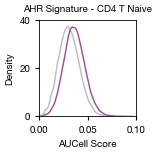

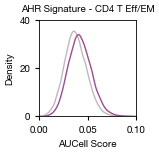

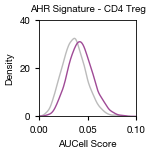

In [6]:
# Define colors for NHC and CI-Sep groups
colors = {
    "NHC": "#BBBBBB",
    "CI-Sep": "#9F4A96"
}

# Loop over each T cell subset and create a separate KDE plot for each
for cell_type in ['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']:
    # Set up the figure with specified dimensions
    plt.figure(figsize=(1.25, 1.25))
    
    # Subset the data for the current cell type
    cell_type_df = df_aucell[df_aucell['CellType'] == cell_type]
    
    # Plot KDE for NHC and CI-Sep within the current cell type subset
    for group in colors:
        group_scores = cell_type_df.loc[cell_type_df['Group'] == group, 'AUCell Scores']
        sns.kdeplot(group_scores, color=colors[group], lw=1, fill=False)
    
    # Customize x and y-axis limits and tick marks
    plt.xlim(0, 0.1)
    plt.xticks([0, 0.05, 0.1])
    plt.ylim(0, 40)
    plt.yticks([0, 20, 40])
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    
    # Add labels and title
    plt.xlabel('AUCell Score')
    plt.ylabel('Density')
    plt.title(f'AHR Signature - {cell_type}')
    
    # Clean up cell type name for the filename
    filename = f'ahr_{cell_type.replace(" ", "_").replace("/", "_")}.svg'
    
    # Save the plot with a dynamic filename
    plt.savefig(filename, format='svg')
    plt.show()

In [13]:
# Calculate the mean and standard deviation for each Group + CellType combination
summary_stats = df_aucell.groupby(['Group', 'CellType'])['AUCell Scores'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
summary_stats.columns = ['Group', 'CellType', 'Mean AUCell Score', 'Standard Deviation']

# Print the summary statistics in a tabular format
print(summary_stats)

    Group      CellType  Mean AUCell Score  Standard Deviation
0  CI-Sep  CD4 T Eff/EM           0.042135            0.011962
1  CI-Sep   CD4 T Naive           0.036234            0.010745
2  CI-Sep      CD4 Treg           0.042777            0.013010
3     NHC  CD4 T Eff/EM           0.037401            0.011533
4     NHC   CD4 T Naive           0.030767            0.010683
5     NHC      CD4 Treg           0.036117            0.012482


In [14]:
# Assuming df_aucell is your AUCell scores DataFrame, with columns 'AUCell Scores', 'Group', and 'CellType'
df = df_aucell.copy()  # If df_aucell is the result DataFrame from your previous step

# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt((var1 + var2) / 2)
    return (mean2 - mean1) / pooled_std  # Swap the order for CI-Sep vs NHC

# Assuming df_aucell contains 'AUCell Scores', 'Group', and 'CellType'
# Iterate through each unique cell type
effect_sizes = []  # List to store results

for cell_type in df['CellType'].unique():
    # Subset the data for the current cell type
    cell_type_df = df[df['CellType'] == cell_type]
    
    # Separate the groups (NHC and CI-Sep)
    group1 = cell_type_df[cell_type_df['Group'] == 'NHC']['AUCell Scores']
    group2 = cell_type_df[cell_type_df['Group'] == 'CI-Sep']['AUCell Scores']
    
    # Perform Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
    
    # Calculate Cohen's d (CI-Sep compared to NHC)
    cohen_d = cohens_d(group1, group2)
    
    # Store the results
    effect_sizes.append({
        'CellType': cell_type,
        'Mann-Whitney U p-value': p_value,
        'Cohen\'s d': cohen_d
    })

# Convert the results to a DataFrame
effect_size_df = pd.DataFrame(effect_sizes)

# Print the results
print(effect_size_df)

       CellType  Mann-Whitney U p-value  Cohen's d
0   CD4 T Naive            0.000000e+00   0.510251
1  CD4 T Eff/EM            0.000000e+00   0.402896
2      CD4 Treg           6.445182e-111   0.522424
